In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")

In [3]:
import eventx
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import io
import pickle

from pathlib import Path
from typing import List
from itertools import chain, accumulate
from tqdm import tqdm

from eventx.predictors.predictor_utils import load_predictor
from eventx.models.model_utils import batched_predict_json
from eventx.predictors import snorkel_predictor, smartdata_predictor
from eventx.util import scorer, utils, evaluate, corpus_statistics
from eventx import SD4M_RELATION_TYPES, ROLE_LABELS

from allennlp.predictors import Predictor

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rcParams["font.family"] = "Palatino"
plt.rcParams['pdf.fonttype'] = 42
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# round to two decimal places in python pandas 
pd.options.display.float_format = '{:.2f}'.format
try:
    pd.set_option('display.max_colwidth', None)
except:    
    pd.set_option('display.max_colwidth', -1)

In [4]:
CUDA_DEVICE = -1  # or -1 if no GPU is available

In [5]:
# Change paths
DATASET_PATH = Path("../../data/daystream_corpus")
                    
TRAIN_PATH = DATASET_PATH.joinpath("train/train_with_events_and_defaults.jsonl")  # DATASET_PATH.joinpath("train/train_sd4m_with_events.jsonl")
DEV_PATH = DATASET_PATH.joinpath("dev/dev_with_events_and_defaults.jsonl")
TEST_PATH_SF = DATASET_PATH.joinpath("test/test_with_events_and_defaults.jsonl")  # duplicates are removed as the data is converted to the Snorkel format
DAYSTREAM_TRAIN_PATH = DATASET_PATH.joinpath("daystream_snorkeled_with_abstains.jsonl")
MERGED_TRAIN_PATH = DATASET_PATH.joinpath("snorkeled_gold_conv_merge_with_abstains.jsonl")
TEST_PATH = DATASET_PATH.joinpath("test/test_sd4m_with_events.jsonl")
SAVE_PATH = Path("../../data/save_files")                     
                    
PREDICTOR_NAME = "snorkel-eventx-predictor"
# PREDICTOR_NAME = "smartdata-eventx-predictor"
SAVE_METRICS_PREDICTIONS = True # save all predictions & metrics to reuse them instead of rerunning predictions every time you open this notebook

## Load the test data, models and do predictions

Filter documents that do not contain any entity of type trigger as they are not relevant for the event extraction task.

In [6]:
test_docs = evaluate.load_test_data(TEST_PATH)

In [7]:
model_base_path = Path("../../data/runs/")
model_names = [
    "snorkel_bert_gold",
    "snorkel_bert_daystream",
    "snorkel_bert_merged",
    "snorkel_bert_mlv_daystream"
]
model_proper_name_map = {
    "snorkel_bert_gold": "SD4M",
    "snorkel_bert_daystream": "Daystream",
    "snorkel_bert_merged": "SD4M + Daystream",
    "snorkel_bert_mlv_daystream": "Daystream (Majority Label Voter)"
}
main_models = ["SD4M", "Daystream", "SD4M + Daystream"]

In [8]:
pred_save_file = SAVE_PATH.joinpath("pred_save_file.pkl")
if pred_save_file.exists() and SAVE_METRICS_PREDICTIONS:
    print(f"Loading predicted documents from {pred_save_file}, instead of running predictions")
    predicted_docs = pickle.load(open(pred_save_file, "rb"))
else:    
    predicted_docs = {}
    for model_name in tqdm(model_names):
        predictor = load_predictor(model_base_path.joinpath(model_name), PREDICTOR_NAME, CUDA_DEVICE)
        predicted_docs[model_name] = batched_predict_json(predictor=predictor, examples=test_docs)
    if SAVE_METRICS_PREDICTIONS:
        print(f"Saving predicted documents to {pred_save_file}")
        pickle.dump(predicted_docs, open(pred_save_file, "wb"))

Loading predicted documents from ../../data/save_files/pred_save_file.pkl, instead of running predictions


## Conventional evaluation using sklearn toolkit
We simply consider the trigger & role label sequences disregarding the correctness of the corresponding trigger label when evaluating the argument roles to use the sklearn toolkit.

In [9]:
trigger_y_pred, arg_y_pred = {}, {}
for model_name in model_names:
    label_arrays = evaluate.get_label_arrays(test_docs, predicted_docs[model_name])
    trigger_y_true, trigger_y_pred[model_name] = label_arrays["trigger_y_true"], label_arrays["trigger_y_pred"]
    arg_y_true, arg_y_pred[model_name] = label_arrays["arg_y_true"], label_arrays["arg_y_pred"]

- SD4M: Model trained with SD4M gold training data
- Daystream (Label Model): Model trained with probabilistically labeled Daystream data (using outputs from user-defined labeling functions weighted with Snorkel LabelModel)
- SD4M + Daystream (Label Model): Model trained with SD4M gold training data augmented with probabilistically labeled Daystream data (Snorkel)
- Daystream (Majority Label Voter): Model trained with probabilistically labeled Daystream data (using outputs from user-defined labeling functions with simple MajorityLabelVoter)

### Trigger classification

#### Model trained with SD4M gold training data

In [10]:
trigger_metrics_dict = {}
for model_name in model_names:
    trigger_metrics_dict[model_name] = pd.DataFrame(sklearn.metrics.classification_report(trigger_y_true, trigger_y_pred[model_name], SD4M_RELATION_TYPES[:-1], output_dict=True)).T

In [11]:
complete_trigger_metrics = pd.concat(trigger_metrics_dict.values(), axis=1, keys=model_proper_name_map.values())*100
complete_trigger_metrics.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'support']]] = complete_trigger_metrics.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'support']]]/100
complete_trigger_metrics.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'support']]] = complete_trigger_metrics.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'support']]].astype('int64')
complete_trigger_metrics_main = complete_trigger_metrics[main_models]
complete_trigger_metrics_main.T

Accident  CanceledRoute  CanceledStop  Delay  \
SD4M             precision     75.00         100.00        100.00 100.00   
                 recall        66.67          80.00        100.00 100.00   
                 f1-score      70.59          88.89        100.00 100.00   
                 support        9.00          10.00          3.00   2.00   
Daystream        precision     88.89         100.00        100.00 100.00   
                 recall        88.89          70.00        100.00 100.00   
                 f1-score      88.89          82.35        100.00 100.00   
                 support        9.00          10.00          3.00   2.00   
SD4M + Daystream precision     80.00         100.00        100.00 100.00   
                 recall        88.89          80.00        100.00 100.00   
                 f1-score      84.21          88.89        100.00 100.00   
                 support        9.00          10.00          3.00   2.00   

                            Obstruction  RailReplacementService  TrafficJam  \
SD4M             precision        92.31                  100.00       87.50   
                 recall          100.00                   80.00       87.50   
                 f1-score         96.00                   88.89       87.50   
                 support          12.00                    5.00       16.00   
Daystream        precision        84.62                  100.00       86.67   
                 recall           91.67                   60.00       81.25   
                 f1-score         88.00                   75.00       83.87   
                 support          12.00                    5.00       16.00   
SD4M + Daystream precision        80.00                  100.00       87.50   
                 recall          100.00                   80.00       87.50   
                 f1-score         88.89                   88.89       87.50   
                 support          12.00                    5.00       16.00   

                            micro avg  macro avg  weighted avg  
SD4M             precision      90.74      93.54         90.92  
                 recall         85.96      87.74         85.96  
                 f1-score       88.29      90.27         88.08  
                 support        57.00      57.00         57.00  
Daystream        precision      90.38      94.31         91.26  
                 recall         82.46      84.54         82.46  
                 f1-score       86.24      88.30         85.90  
                 support        57.00      57.00         57.00  
SD4M + Daystream precision      87.93      92.50         89.12  
                 recall         89.47      90.91         89.47  
                 f1-score       88.70      91.20         88.73  
                 support        57.00      57.00         57.00

In [12]:
complete_trigger_metrics_main.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'f1-score']]].T

,,Accident,CanceledRoute,CanceledStop,Delay,Obstruction,RailReplacementService,TrafficJam,micro avg,macro avg,weighted avg
SD4M,f1-score,70.59,88.89,100.00,100.00,96.00,88.89,87.50,88.29,90.27,88.08
Daystream,f1-score,88.89,82.35,100.00,100.00,88.00,75.00,83.87,86.24,88.30,85.90
SD4M + Daystream,f1-score,84.21,88.89,100.00,100.00,88.89,88.89,87.50,88.70,91.20,88.73


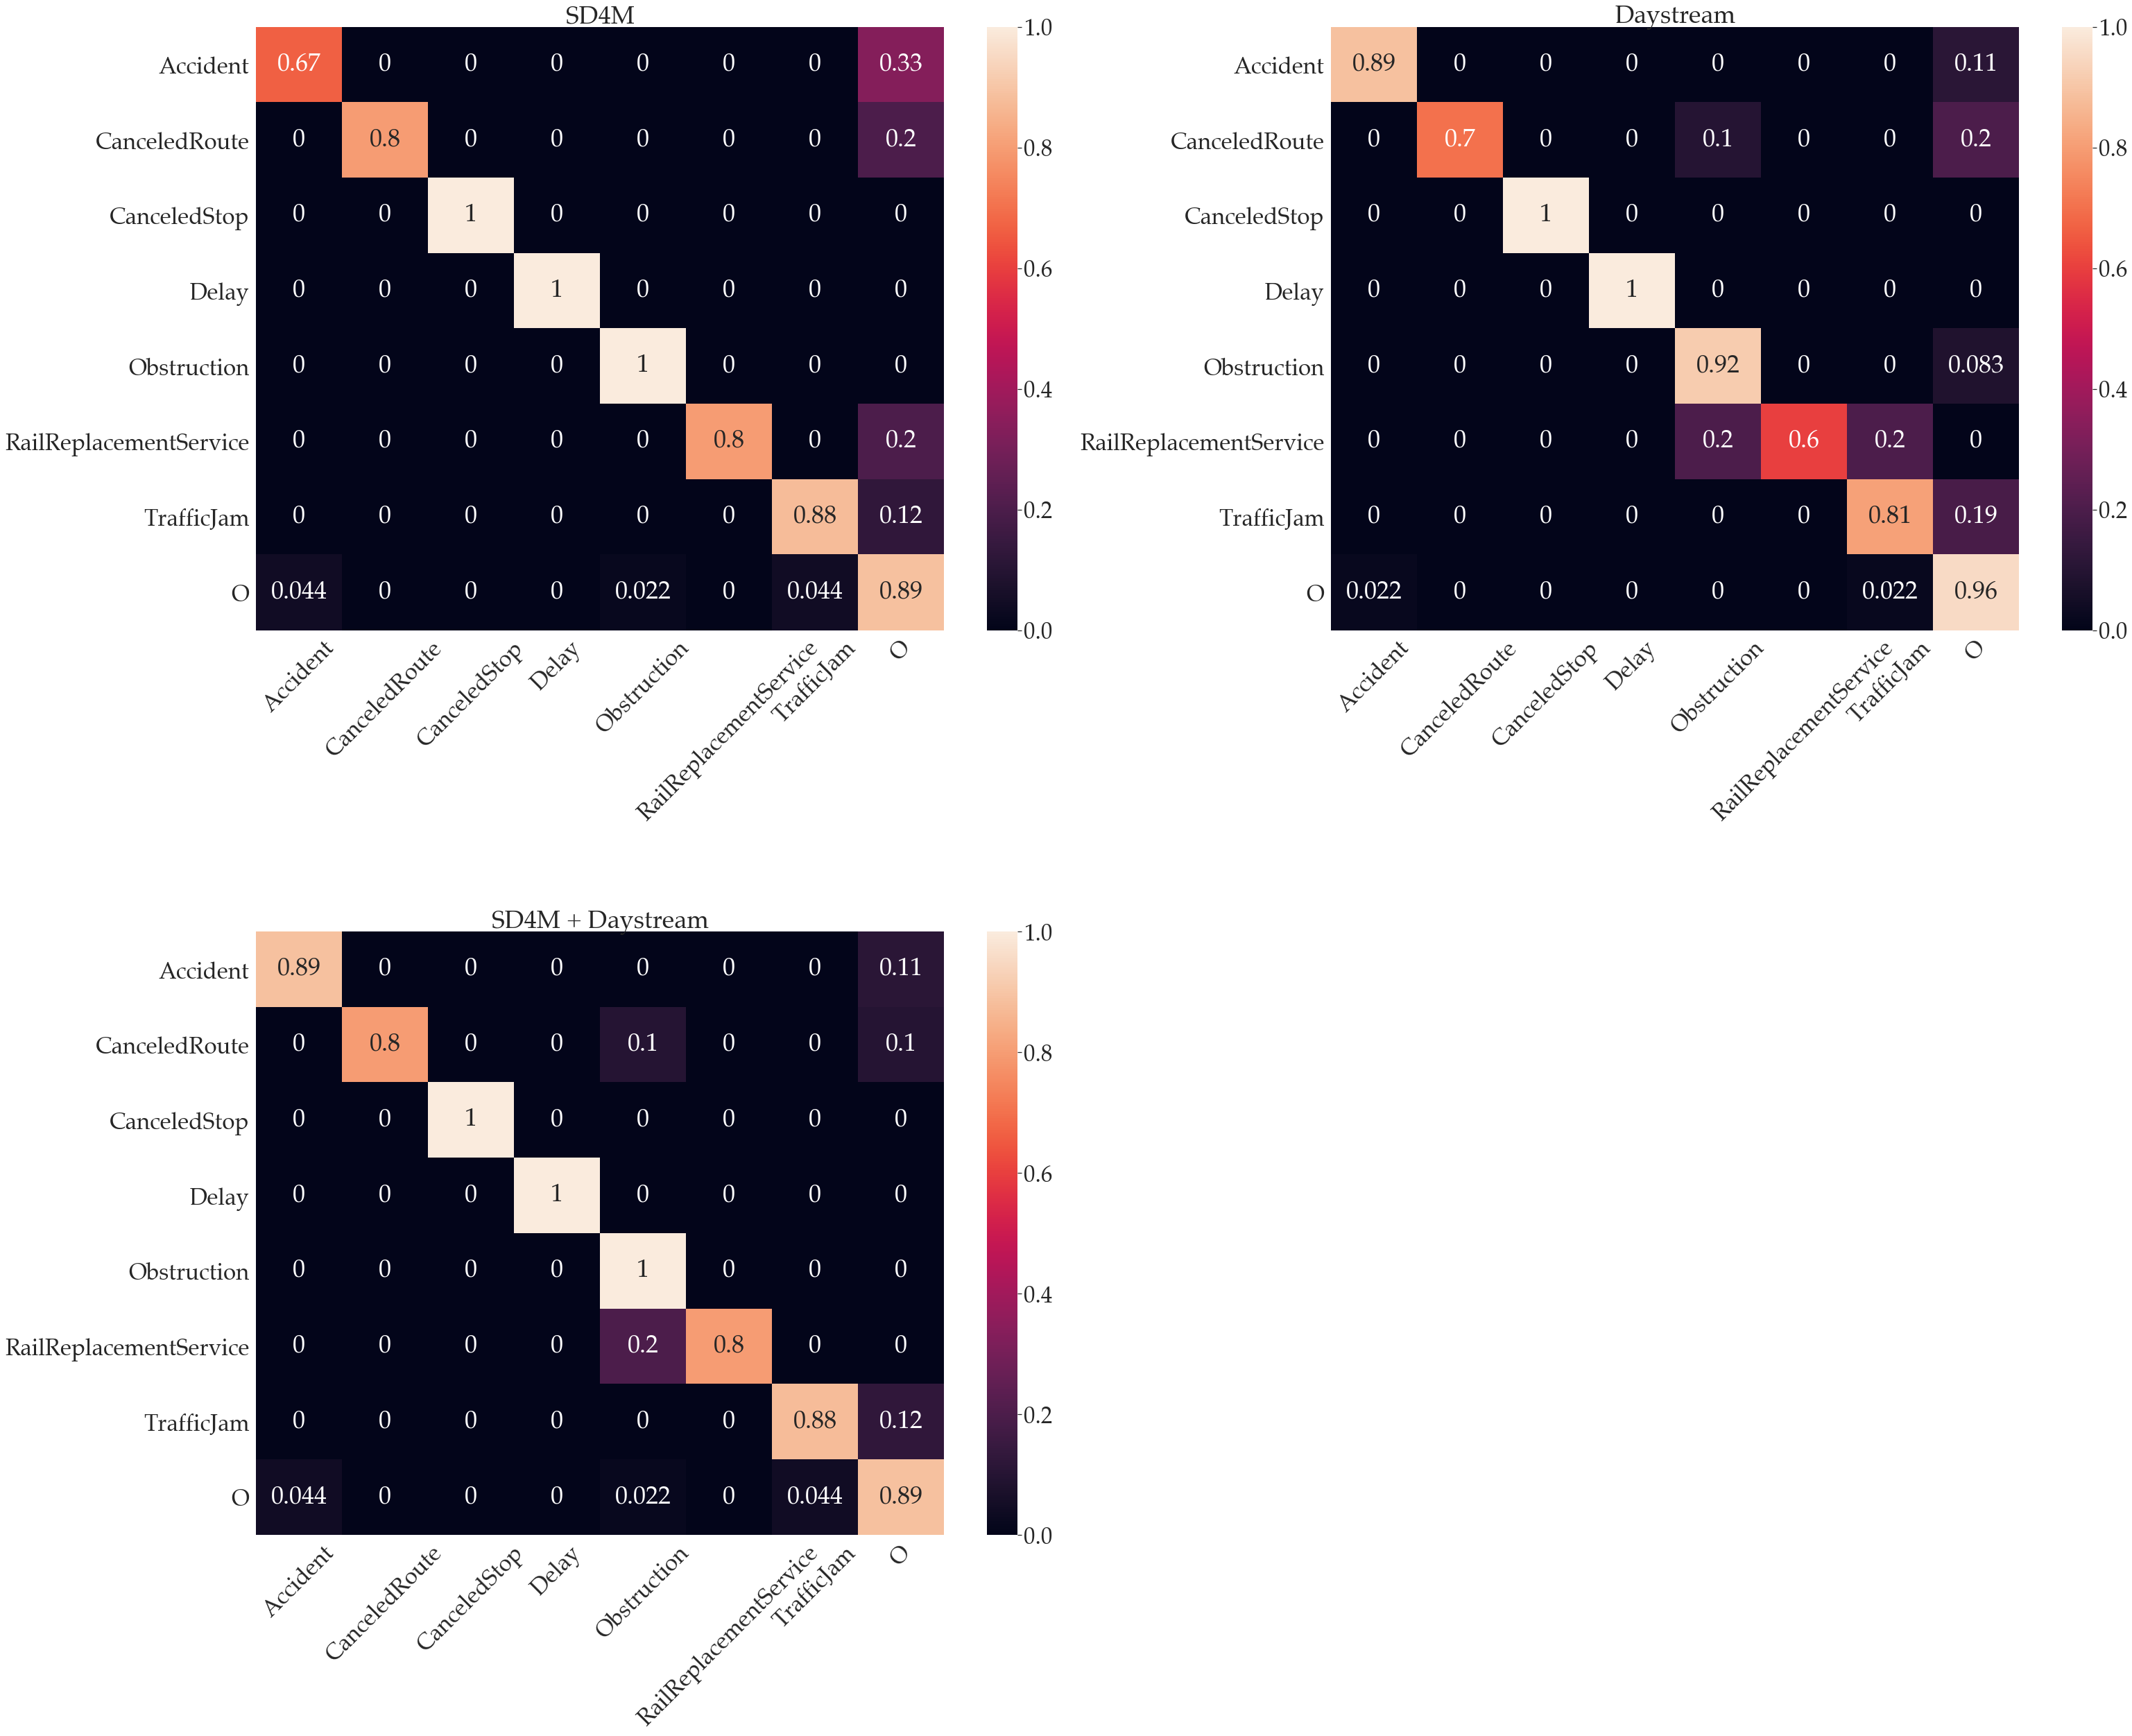

In [13]:
sns.set(font_scale=3, font="Palatino")
f, axes = plt.subplots(2, 2, figsize=(50,40))
# f.suptitle('Normalized Confusion Matrices - Trigger classification')
flat_axes = axes.flatten()
for i, model_name in enumerate(model_names[:-1]):
    cm = sklearn.metrics.confusion_matrix(trigger_y_true, trigger_y_pred[model_name], labels=SD4M_RELATION_TYPES)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = SD4M_RELATION_TYPES, columns = SD4M_RELATION_TYPES).round(3)
    g = sns.heatmap(df_cm, ax=flat_axes[i], annot=True)
    flat_axes[i].set_title(model_proper_name_map[model_name])
    g.set_xticklabels(g.get_xticklabels(), rotation = 45)
    plt.subplots_adjust(wspace=.25, hspace=.5)
f.delaxes(axes[1,1])
f.savefig(SAVE_PATH.joinpath('CM-TriggerClassification.pdf'), bbox_inches='tight')

### Argument role classification

In [14]:
role_metrics_dict = {}
for model_name in model_names[:-1]:
    role_metrics_dict[model_name] = pd.DataFrame(sklearn.metrics.classification_report(arg_y_true, arg_y_pred[model_name], ROLE_LABELS[:-1], output_dict=True)).T

/Users/phuc/opt/miniconda3/envs/eventx/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
complete_role_metrics = pd.concat(role_metrics_dict.values(), axis=1, keys=model_proper_name_map.values())*100
complete_role_metrics.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'support']]] = complete_role_metrics.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'support']]]/100
complete_role_metrics.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'support']]] = complete_role_metrics.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'support']]].astype('int64')
complete_role_metrics_main = complete_role_metrics[main_models]
complete_role_metrics_main.T

location  delay  direction  start_loc  end_loc  \
SD4M             precision     82.81 100.00      87.50      81.58    68.89   
                 recall        63.10  87.50      67.74      79.49    81.58   
                 f1-score      71.62  93.33      76.36      80.52    74.70   
                 support       84.00   8.00      31.00      39.00    38.00   
Daystream        precision     80.00   0.00      82.76      80.00    87.50   
                 recall        47.62   0.00      77.42      82.05    73.68   
                 f1-score      59.70   0.00      80.00      81.01    80.00   
                 support       84.00   8.00      31.00      39.00    38.00   
SD4M + Daystream precision     85.07  88.89      88.46      79.07    76.19   
                 recall        67.86 100.00      74.19      87.18    84.21   
                 f1-score      75.50  94.12      80.70      82.93    80.00   
                 support       84.00   8.00      31.00      39.00    38.00   

                            start_date  end_date  cause  jam_length  route  \
SD4M             precision      100.00     50.00  70.59      100.00  75.00   
                 recall          22.22     50.00  80.00      100.00 100.00   
                 f1-score        36.36     50.00  75.00      100.00  85.71   
                 support          9.00      2.00  15.00       13.00   3.00   
Daystream        precision       70.00    100.00 100.00       92.86 100.00   
                 recall          77.78    100.00  73.33      100.00  33.33   
                 f1-score        73.68    100.00  84.62       96.30  50.00   
                 support          9.00      2.00  15.00       13.00   3.00   
SD4M + Daystream precision      100.00    100.00  66.67       92.86  75.00   
                 recall          33.33     50.00  80.00      100.00 100.00   
                 f1-score        50.00     66.67  72.73       96.30  85.71   
                 support          9.00      2.00  15.00       13.00   3.00   

                            micro avg  macro avg  weighted avg  
SD4M             precision      80.56      81.64         82.03  
                 recall         71.90      73.16         71.90  
                 f1-score       75.98      74.36         75.28  
                 support       242.00     242.00        242.00  
Daystream        precision      83.60      79.31         80.86  
                 recall         65.29      66.52         65.29  
                 f1-score       73.32      70.53         71.19  
                 support       242.00     242.00        242.00  
SD4M + Daystream precision      81.94      85.22         83.10  
                 recall         76.86      77.68         76.86  
                 f1-score       79.32      78.46         78.73  
                 support       242.00     242.00        242.00

In [16]:
complete_role_metrics_main.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'f1-score']]].T

,,location,delay,direction,start_loc,end_loc,start_date,end_date,cause,jam_length,route,micro avg,macro avg,weighted avg
SD4M,f1-score,71.62,93.33,76.36,80.52,74.70,36.36,50.00,75.00,100.00,85.71,75.98,74.36,75.28
Daystream,f1-score,59.70,0.00,80.00,81.01,80.00,73.68,100.00,84.62,96.30,50.00,73.32,70.53,71.19
SD4M + Daystream,f1-score,75.50,94.12,80.70,82.93,80.00,50.00,66.67,72.73,96.30,85.71,79.32,78.46,78.73


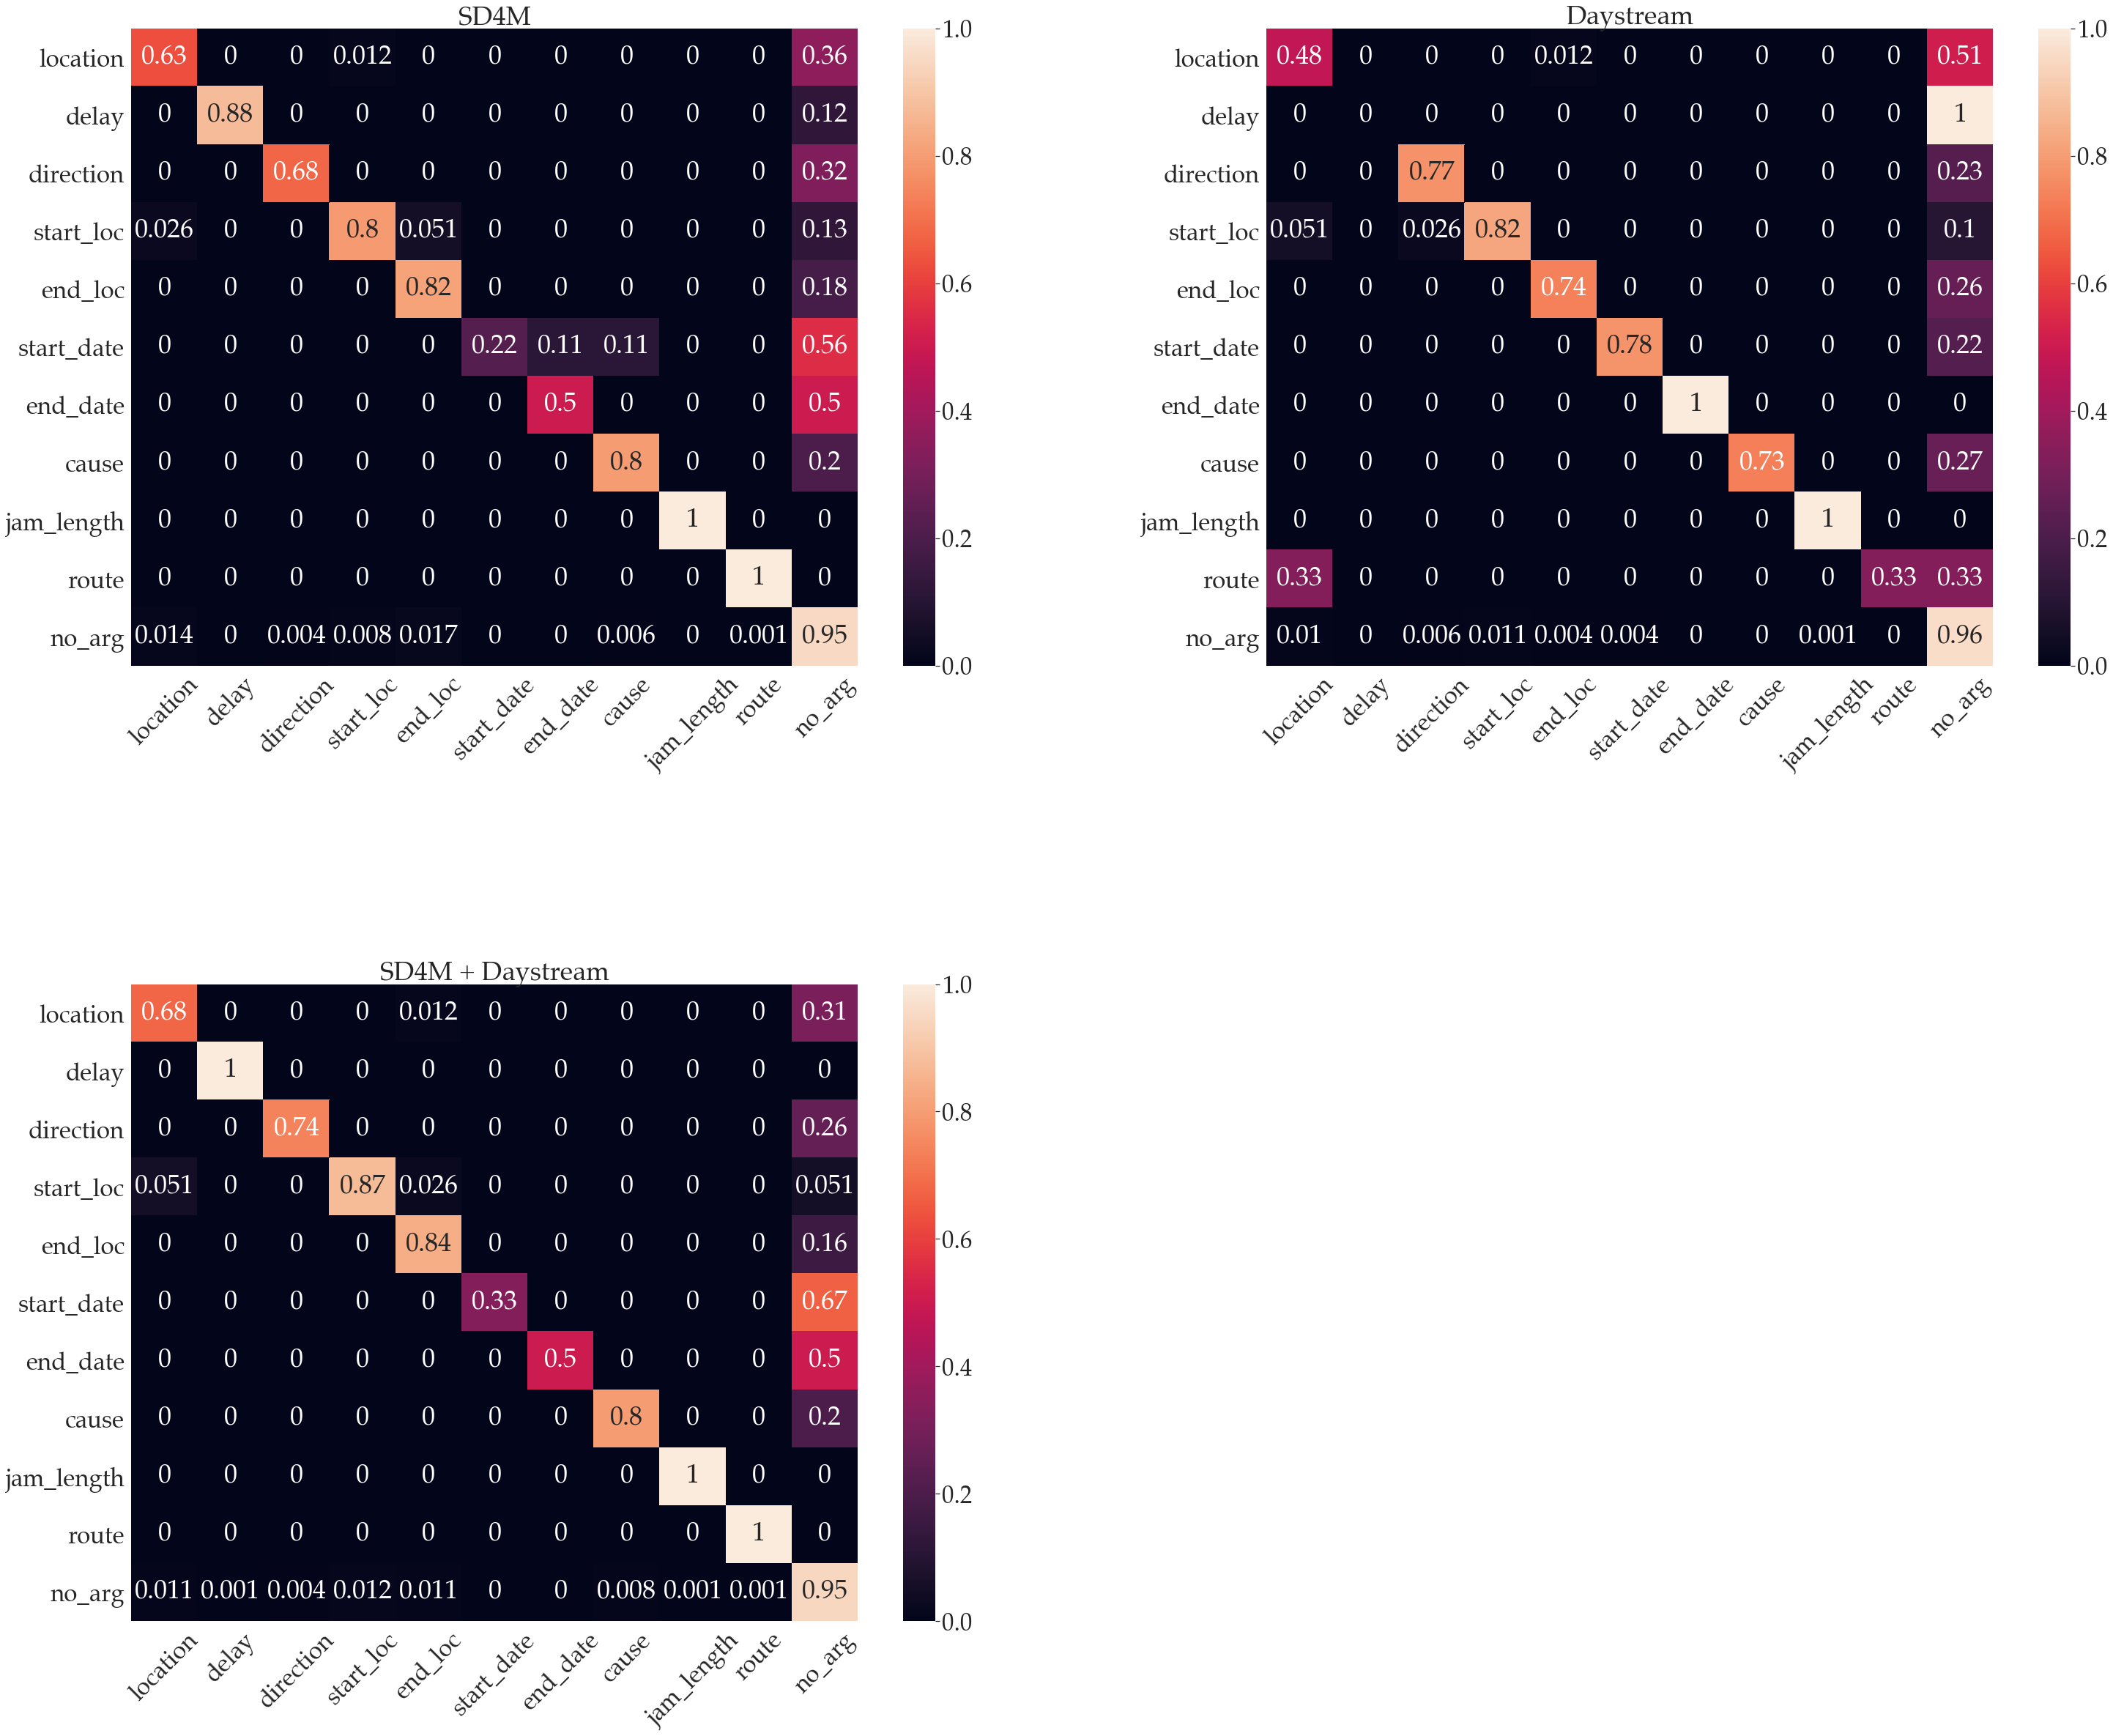

In [17]:
sns.set(font_scale=3, font="Palatino")
f, axes = plt.subplots(2, 2, figsize=(50,40))
# f.suptitle('Normalized Confusion Matrices - Argument classification')
flat_axes = axes.flatten()
for i, model_name in enumerate(model_names[:-1]):
    cm = sklearn.metrics.confusion_matrix(arg_y_true, arg_y_pred[model_name], labels=ROLE_LABELS)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=ROLE_LABELS, columns=ROLE_LABELS).round(3)
    g = sns.heatmap(df_cm, ax=flat_axes[i], annot=True)
    flat_axes[i].set_title(model_proper_name_map[model_name])
    g.set_xticklabels(g.get_xticklabels(), rotation = 45)
    plt.subplots_adjust(wspace=.25, hspace=.5)
f.delaxes(axes[1,1])
f.savefig(SAVE_PATH.joinpath('CM-RoleClassification.pdf'), bbox_inches='tight')

## Examining the predictions

The original corpus was annotated with n-ary relations, which we converted to events. A relation was only annotated if all the required arguments (for mobility events usually `trigger` and `location`) were in the same sentence. The annotators were asked to determine whether they were in the same sentence based on the syntax and punctuation, i.e. they were presented with the full document text during the annotation process and had to mentally draw the sentence boundaries.
While examining the corpus we found the quality of the automatic sentence splitting with stanfordnlp insufficient as it struggled with the many abbreviations, dates, hashtags that are prevalent in the corpus texts. 
We observed 92 instances in the SD4M training split, where the trigger and the argument ended up in different sentences according to the stanfordnlp sentence splitter and would have been lost if we fed the model the sentences instead of documents.
That is why we chose to feed entire documents into the model as opposed to feeding it single sentences.

Due to the nature of the annotation (sentence level n-ary relations converted to events) and the input format (document level) it could be that the model predicts correct document level positive argument roles - where trigger and argument are not in the same sentence - that are not annotated in the gold data.
There is also the possibility of false positives for event triggers that are not actually false positives, i.e. event triggers that were not annotated as such because a required argument (`location`) was missing. According to the annotation guidelines this should not happen as the annotators were asked to only annotate `trigger` entities as such only if a relation is expressed in the sentence, i.e. the potential event trigger was most likely not even annotated as a `trigger` entity and is not recognized as a potential event trigger by the eventx model.
We manually examine the predictions and look for such instances.

In [18]:
def get_events_sm(doc):
    events_sm = []
    for event in doc['events']:
        trigger = event['trigger']
        trigger_sm = {key:trigger[key] for key in ['text', 'start', 'end']}
        args = event['arguments']
        args_sm = [{key:arg[key] for key in ['text', 'entity_type', 'start', 'end', 'role']} for arg in args]
        events_sm.append({
            'event_type': event['event_type'],
            'trigger': trigger_sm,
            'arguments': args_sm
        })
    return events_sm

def get_entities_sm(x):
    entities_sm = []
    sorted_entities = sorted(x['entities'], key=lambda k: k['start'])
    for entity in sorted_entities:
        entity_sm = {
            'text': entity['text'],
            'entity_type': entity['entity_type'],
            'start': entity['start'],
            'end': entity['end']
        }
        entities_sm.append(entity_sm)
    return entities_sm

def set_sm(df):
    df['events_sm'] = df.apply(lambda doc: get_events_sm(doc), axis=1)
    df['entities_sm'] = df.apply(lambda doc: get_entities_sm(doc), axis=1)
    return df

In [19]:
sm_test_docs = set_sm(pd.DataFrame(test_docs))
pred_docs_df = pd.DataFrame(predicted_docs['snorkel_bert_daystream'])[['words', 'events']]
pred_docs_df['entities_sm'] = sm_test_docs['entities_sm']
pred_docs_df['events_sm'] = sm_test_docs['events_sm']
pred_docs_df['text'] = sm_test_docs['text']

In [20]:
pred_docs_df.loc[[54]][['text', 'entities_sm', 'events', 'events_sm']]

,text,entities_sm,events,events_sm
54,Die A46 Düsseldorf / Wuppertal ist zwischen Düsseldorf-Holthausen und Düsseldorf-Bilk in beiden Richtungen wegen Überflutung gesperrt. Zurzeit 2 km Stau in Richtung Düsseldorf. Der Universitätstunnel und der Tunnel Wersten stehen unter Wasser.\n,"[{'text': 'A46', 'entity_type': 'location_street', 'start': 1, 'end': 2}, {'text': 'Düsseldorf', 'entity_type': 'location_city', 'start': 2, 'end': 3}, {'text': 'Wuppertal', 'entity_type': 'location_city', 'start': 4, 'end': 5}, {'text': 'Düsseldorf-Holthausen', 'entity_type': 'location', 'start': 7, 'end': 10}, {'text': 'Düsseldorf-Bilk', 'entity_type': 'location', 'start': 11, 'end': 14}, {'text': 'beiden Richtungen', 'entity_type': 'location', 'start': 15, 'end': 17}, {'text': 'Überflutung', 'entity_type': 'trigger', 'start': 18, 'end': 19}, {'text': 'Überflutung', 'entity_type': 'trigger', 'start': 18, 'end': 19}, {'text': 'gesperrt', 'entity_type': 'trigger', 'start': 19, 'end': 20}, {'text': '2 km', 'entity_type': 'distance', 'start': 22, 'end': 24}, {'text': 'Stau', 'entity_type': 'trigger', 'start': 24, 'end': 25}, {'text': 'Düsseldorf', 'entity_type': 'location_city', 'start': 27, 'end': 28}, {'text': 'Universitätstunnel', 'entity_type': 'location_street', 'start': 30, 'end': 31}, {'text': 'Tunnel Wersten', 'entity_type': 'location_street', 'start': 33, 'end': 35}]","[{'event_type': 'TrafficJam', 'trigger': {'text': 'Stau', 'start': 24, 'end': 25}, 'arguments': [{'text': '2 km', 'start': 22, 'end': 24, 'role': 'jam_length'}]}, {'event_type': 'Obstruction', 'trigger': {'text': 'gesperrt', 'start': 19, 'end': 20}, 'arguments': [{'text': 'beiden Richtungen', 'start': 15, 'end': 17, 'role': 'direction'}, {'text': 'Düsseldorf', 'start': 27, 'end': 28, 'role': 'direction'}, {'text': 'Düsseldorf - Bilk', 'start': 11, 'end': 14, 'role': 'end_loc'}, {'text': 'Wuppertal', 'start': 4, 'end': 5, 'role': 'direction'}, {'text': 'Düsseldorf', 'start': 2, 'end': 3, 'role': 'start_loc'}, {'text': 'A46', 'start': 1, 'end': 2, 'role': 'location'}, {'text': 'Düsseldorf - Holthausen', 'start': 7, 'end': 10, 'role': 'start_loc'}, {'text': 'Überflutung', 'start': 18, 'end': 19, 'role': 'cause'}]}]","[{'event_type': 'Obstruction', 'trigger': {'text': 'gesperrt', 'start': 19, 'end': 20}, 'arguments': [{'text': 'Düsseldorf-Holthausen', 'entity_type': 'location', 'start': 7, 'end': 10, 'role': 'start_loc'}, {'text': 'Düsseldorf-Bilk', 'entity_type': 'location', 'start': 11, 'end': 14, 'role': 'end_loc'}, {'text': 'Überflutung', 'entity_type': 'trigger', 'start': 18, 'end': 19, 'role': 'cause'}, {'text': 'A46', 'entity_type': 'location-street', 'start': 1, 'end': 2, 'role': 'location'}, {'text': 'beiden Richtungen', 'entity_type': 'location', 'start': 15, 'end': 17, 'role': 'direction'}]}]"


There were 68 documents in the test set, of which 23 contained multiple sentences and 45 consisted of a single sentence.
We observed that the model trained on the gold SD4M training data predicted 16 wrong arguments that were not in the same sentence as the trigger, but found one instance, where the model predicted a correct location argument in a preceding sentence for a `TrafficJam` trigger. That `TrafficJam` event was not annotated in the gold data as the required `location` argument was not in the same sentence as the trigger. According to the annotation guidelines that trigger should not have been annotated as a trigger entity.

> Die **A46**\[`location`\] Düsseldorf / Wuppertal ist zwischen Düsseldorf-Holthausen und Düsseldorf-Bilk in beiden Richtungen wegen Überflutung gesperrt. Zurzeit 2 km **Stau**\[`TrafficJam`\] in Richtung Düsseldorf. Der Universitätstunnel und der Tunnel Wersten stehen unter Wasser.

The model that was trained on the probabilistically labeled Daystream data and the model that was trained on the combined training set predicted a correct `jam_length` argument for that same `TrafficJam` event, which was counted as a false positive because the event was not annotated in the gold data due to the required `location` argument not being in the same sentence.

> Die A46 Düsseldorf / Wuppertal ist zwischen Düsseldorf-Holthausen und Düsseldorf-Bilk in beiden Richtungen wegen Überflutung gesperrt. Zurzeit **2 km**\[`jam_length` \] **Stau**\[`TrafficJam`\] in Richtung Düsseldorf. Der Universitätstunnel und der Tunnel Wersten stehen unter Wasser.

For the model that was trained on the probabilistically labeled Daystream data, we observed 4 instances, where the model predicted wrong arguments that were not in the same sentence as the trigger. We found 2 instances, where the model predicted correct date arguments that were in the preceding sentence of the trigger.

> folgende Meldung korrigiert
>
> von **Mittwoch, 23. März**\[`start_date`\], 22.10 Uhr bis Dienstag, 29. März, 7.45 Uhr
> 
> Meldung:
> 
> Die EC-Züge werden zwischen Berlin Hbf und Frankfurt (Oder) durch **Busse ersetzt**\[`RailReplacementService`\]. \[...\]

> am **Dienstag, 2. August**\[`start_date`\], 3.00 – 3.45 Uhr
> 
> Meldung:
> 
> IC 2020 nach Hamburg-Altona (23.24 Uhr ab Frankfurt (Main) Hbf) wird von Essen Hbf bis Dortmund Hbf **umgeleitet**\[`Obstruction`\] und hält nicht in Bochum Hbf.

For the model that was trained on the combined training set, we found 3 instances, where it predicted wrong arguments that were not in the same sentence as the trigger.

## Event extraction evaluation using correctness criteria defined by Ji, Heng and Grishman, Ralph 2008

Ji, Heng and Grishman, Ralph (2008). Refining event extraction through cross-document inference.
> - A trigger is correctly labeled if its event type and offsets match a reference trigger.
> - An argument is correctly identified if its event type and offsets match any of the reference argument mentions.
> - An argument is correctly identified and classified if its event type, offsets, and role match any of the reference argument mentions.

The main difference to the previous evaluation method lies in the correctness criteria for the arguments. Here we additionally consider the correctness of the event type for the argument.

Caution:
Using the following methods to retrieve the triggers and arguments from the gold data might result in duplicate gold triggers & arguments.
This is due to different events possibly sharing the same trigger.
The model is not able to distinguish such events and instead fuses them all together, which results in lower recall.
If we remove duplicates from the gold triggers and gold arguments, recall and consequently f1 should be higher.

In [21]:
REMOVE_DUPLICATES = True  # change to False if you want to keep duplicate triggers/ arguments from the gold data caused by events sharing the same trigger

In [22]:
gold_triggers = scorer.get_triggers(test_docs)
gold_arguments = scorer.get_arguments(test_docs)
print(f'Number of gold triggers: {len(gold_triggers)}')
print(f'Number of gold arguments: {len(gold_triggers)}')

Number of gold triggers: 62
Number of gold arguments: 62


In [23]:
if REMOVE_DUPLICATES:
    gold_triggers = list(set(gold_triggers))
    gold_arguments = list(set(gold_arguments))
    print(f'After removing duplicate triggers/ arguments from the gold data caused by events sharing the same trigger')
    print(f'Number of unique gold triggers: {len(gold_triggers)}')
    print(f'Number of unique gold arguments: {len(gold_triggers)}')

After removing duplicate triggers/ arguments from the gold data caused by events sharing the same trigger
Number of unique gold triggers: 57
Number of unique gold arguments: 57


### 5 Repeated Runs
5 repeated runs for each configuration with random seeds for the snorkel label models and eventx model.
Metrics are given as mean & standard deviation.

In [24]:
model_base_path = Path("../../data/runs/random_repeats")
runs = 5
rr_save_file = SAVE_PATH.joinpath("saved_metrics.pkl")  # if the models don't change, we can use this instead rerunning all the models
if rr_save_file.exists() and SAVE_METRICS_PREDICTIONS:
    print(f"Loading metrics from {rr_save_file}, using those instead of running predictions")
    trigger_metrics_rr, argument_metrics_rr = pickle.load(open(rr_save_file, "rb"))
else:
    trigger_metrics_rr, argument_metrics_rr = {}, {}
    for model_name in model_names:
        print(model_name)
        model_paths = [model_base_path.joinpath(f'run_{run+1}/{model_name}') for run in range(runs)]
        trigger_metrics_rr[model_name], argument_metrics_rr[model_name] = evaluate.summize_multiple_runs(model_paths, test_docs)
    if SAVE_METRICS_PREDICTIONS:
        print(f"Saving metrics to {rr_save_file}")
        pickle.dump((trigger_metrics_rr, argument_metrics_rr), open(rr_save_file, "wb"))

Loading metrics from ../../data/save_files/saved_metrics.pkl, using those instead of running predictions


In [25]:
trigger_related_categories = ["Trigger identification", "Trigger classification"] + SD4M_RELATION_TYPES[:-1]
role_related_categories = ["Argument identification", "Argument classification"] + ROLE_LABELS[:-1]

In [26]:
formatted_metrics = {}
for model_name in model_names:
    formatted_trigger = evaluate.format_classification_report(evaluate.get_mean_std(trigger_metrics_rr[model_name]), make_string=True)
    formatted_argument = evaluate.format_classification_report(evaluate.get_mean_std(argument_metrics_rr[model_name]), make_string=True)
    formatted_metrics[model_proper_name_map[model_name]] = pd.concat([formatted_trigger, formatted_argument])
    formatted_metrics[model_proper_name_map[model_name]].set_index('row_name', inplace=True)

In [27]:
complete_metrics = pd.concat(formatted_metrics.values(), axis=1, keys=model_proper_name_map.values())
complete_metrics_main = complete_metrics[main_models]

In [28]:
complete_metrics_main.T[trigger_related_categories]

row_name                   Trigger identification Trigger classification  \
SD4M             precision            92.0+/- 0.7            90.5+/- 1.7   
                 recall               88.4+/- 1.4            87.0+/- 1.8   
                 f1-score             90.2+/- 0.6            88.7+/- 1.5   
                 support                       57                     57   
Daystream        precision            92.3+/- 2.6            87.7+/- 2.4   
                 recall               83.9+/- 3.0            79.6+/- 3.3   
                 f1-score             87.9+/- 2.3            83.4+/- 2.5   
                 support                       57                     57   
SD4M + Daystream precision            92.6+/- 0.7            88.7+/- 2.3   
                 recall               91.9+/- 1.8            88.1+/- 2.0   
                 f1-score             92.2+/- 1.1            88.4+/- 2.0   
                 support                       57                     57   

row_name                        Accident CanceledRoute  CanceledStop  \
SD4M             precision   81.9+/- 4.9  100.0+/- 0.0  100.0+/- 0.0   
                 recall     80.0+/- 10.9   80.0+/- 0.0  100.0+/- 0.0   
                 f1-score    80.6+/- 6.7   88.9+/- 0.0  100.0+/- 0.0   
                 support               9            10             3   
Daystream        precision   84.6+/- 6.0  100.0+/- 0.0  40.0+/- 49.0   
                 recall      93.3+/- 5.4   66.0+/- 8.0  20.0+/- 26.7   
                 f1-score    88.5+/- 3.6   79.2+/- 5.6  26.0+/- 33.2   
                 support               9            10             3   
SD4M + Daystream precision   79.5+/- 1.5  100.0+/- 0.0  100.0+/- 0.0   
                 recall      86.7+/- 8.3   78.0+/- 4.0  100.0+/- 0.0   
                 f1-score    82.8+/- 4.6   87.6+/- 2.6  100.0+/- 0.0   
                 support               9            10             3   

row_name                           Delay  Obstruction RailReplacementService  \
SD4M             precision  100.0+/- 0.0  88.5+/- 5.8           95.0+/- 10.0   
                 recall     100.0+/- 0.0  88.3+/- 6.7            76.0+/- 8.0   
                 f1-score   100.0+/- 0.0  88.3+/- 5.4            84.4+/- 8.9   
                 support               2           12                      5   
Daystream        precision  100.0+/- 0.0  79.9+/- 4.3           100.0+/- 0.0   
                 recall     90.0+/- 20.0  91.7+/- 0.0            64.0+/- 8.0   
                 f1-score   93.3+/- 13.3  85.3+/- 2.5            77.8+/- 5.6   
                 support               2           12                      5   
SD4M + Daystream precision  86.7+/- 16.3  86.7+/- 5.2           100.0+/- 0.0   
                 recall     100.0+/- 0.0  96.7+/- 4.1            76.0+/- 8.0   
                 f1-score    92.0+/- 9.8  91.4+/- 4.5            86.1+/- 5.6   
                 support               2           12                      5   

row_name                     TrafficJam  
SD4M             precision  88.2+/- 0.0  
                 recall     93.8+/- 0.0  
                 f1-score   90.9+/- 0.0  
                 support             16  
Daystream        precision  87.4+/- 3.9  
                 recall     86.2+/- 4.7  
                 f1-score   86.8+/- 3.7  
                 support             16  
SD4M + Daystream precision  86.6+/- 2.2  
                 recall     88.8+/- 2.5  
                 f1-score   87.7+/- 1.9  
                 support             16

In [29]:
complete_metrics_main.T[role_related_categories]

row_name                   Argument identification Argument classification  \
SD4M             precision             80.7+/- 1.8             78.2+/- 1.8   
                 recall                75.4+/- 3.4             73.1+/- 3.2   
                 f1-score              77.9+/- 1.8             75.5+/- 1.8   
                 support                       244                     244   
Daystream        precision             82.6+/- 3.5             78.9+/- 4.9   
                 recall                62.1+/- 4.6             59.2+/- 3.5   
                 f1-score              70.8+/- 2.9             67.5+/- 2.6   
                 support                       244                     244   
SD4M + Daystream precision             85.3+/- 3.1             83.4+/- 3.3   
                 recall                79.2+/- 2.1             77.4+/- 2.2   
                 f1-score              82.1+/- 2.4             80.3+/- 2.5   
                 support                       244                     244   

row_name                       location         delay    direction  \
SD4M             precision  78.9+/- 1.7   96.0+/- 8.0  80.3+/- 1.6   
                 recall     63.1+/- 3.3  95.0+/- 10.0  75.5+/- 7.2   
                 f1-score   70.1+/- 2.2   94.9+/- 6.3  77.6+/- 3.4   
                 support             84             8           31   
Daystream        precision  77.7+/- 3.3    0.0+/- 0.0  80.2+/- 7.1   
                 recall     44.3+/- 8.6    0.0+/- 0.0  71.0+/- 2.0   
                 f1-score   55.8+/- 7.6    0.0+/- 0.0  75.2+/- 3.8   
                 support             84             8           31   
SD4M + Daystream precision  82.8+/- 4.2   97.8+/- 4.4  83.0+/- 3.2   
                 recall     69.5+/- 2.7   97.5+/- 5.0  78.1+/- 2.4   
                 f1-score   75.6+/- 3.1   97.5+/- 3.1  80.4+/- 2.3   
                 support             84             8           31   

row_name                      start_loc      end_loc    start_date  \
SD4M             precision  75.8+/- 6.1  72.1+/- 2.5  86.7+/- 16.3   
                 recall     83.6+/- 4.5  82.1+/- 2.8   22.2+/- 0.0   
                 f1-score   79.2+/- 3.0  76.7+/- 2.1   35.2+/- 1.5   
                 support             39           39             9   
Daystream        precision  75.9+/- 7.8  78.9+/- 5.9  55.7+/- 13.4   
                 recall     75.4+/- 2.6  67.2+/- 2.5   42.2+/- 8.3   
                 f1-score   75.4+/- 4.3  72.4+/- 3.1  47.8+/- 10.2   
                 support             39           39             9   
SD4M + Daystream precision  84.8+/- 4.1  81.6+/- 6.6  87.0+/- 10.8   
                 recall     85.6+/- 3.5  83.6+/- 3.1   46.7+/- 8.3   
                 f1-score   85.2+/- 3.6  82.4+/- 4.0   60.7+/- 9.7   
                 support             39           39             9   

row_name                        end_date        cause    jam_length  \
SD4M             precision  56.7+/- 22.6  76.1+/- 3.2   94.3+/- 2.9   
                 recall      33.3+/- 0.0  72.0+/- 5.0  100.0+/- 0.0   
                 f1-score    40.7+/- 5.3  73.9+/- 3.8   97.0+/- 1.5   
                 support               3           15            13   
Daystream        precision  93.3+/- 13.3  90.1+/- 8.2   90.5+/- 4.6   
                 recall     46.7+/- 16.3  76.0+/- 3.3  100.0+/- 0.0   
                 f1-score   59.3+/- 12.2  82.1+/- 2.9   95.0+/- 2.7   
                 support               3           15            13   
SD4M + Daystream precision  100.0+/- 0.0  73.7+/- 4.3   92.9+/- 0.0   
                 recall      33.3+/- 0.0  74.7+/- 5.0  100.0+/- 0.0   
                 f1-score    50.0+/- 0.0  74.2+/- 4.5   96.3+/- 0.0   
                 support               3           15            13   

row_name                           route  
SD4M             precision  85.0+/- 12.2  
                 recall     100.0+/- 0.0  
                 f1-score    91.4+/- 7.0  
                 support               3  
Daystream        precisi

A more compact view:

In [30]:
complete_metrics_main.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'f1-score']]].T[trigger_related_categories]

,row_name,Trigger identification,Trigger classification,Accident,CanceledRoute,CanceledStop,Delay,Obstruction,RailReplacementService,TrafficJam
SD4M,f1-score,90.2+/- 0.6,88.7+/- 1.5,80.6+/- 6.7,88.9+/- 0.0,100.0+/- 0.0,100.0+/- 0.0,88.3+/- 5.4,84.4+/- 8.9,90.9+/- 0.0
Daystream,f1-score,87.9+/- 2.3,83.4+/- 2.5,88.5+/- 3.6,79.2+/- 5.6,26.0+/- 33.2,93.3+/- 13.3,85.3+/- 2.5,77.8+/- 5.6,86.8+/- 3.7
SD4M + Daystream,f1-score,92.2+/- 1.1,88.4+/- 2.0,82.8+/- 4.6,87.6+/- 2.6,100.0+/- 0.0,92.0+/- 9.8,91.4+/- 4.5,86.1+/- 5.6,87.7+/- 1.9


In [31]:
complete_metrics_main.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'f1-score']]].T[role_related_categories]

,row_name,Argument identification,Argument classification,location,delay,direction,start_loc,end_loc,start_date,end_date,cause,jam_length,route
SD4M,f1-score,77.9+/- 1.8,75.5+/- 1.8,70.1+/- 2.2,94.9+/- 6.3,77.6+/- 3.4,79.2+/- 3.0,76.7+/- 2.1,35.2+/- 1.5,40.7+/- 5.3,73.9+/- 3.8,97.0+/- 1.5,91.4+/- 7.0
Daystream,f1-score,70.8+/- 2.9,67.5+/- 2.6,55.8+/- 7.6,0.0+/- 0.0,75.2+/- 3.8,75.4+/- 4.3,72.4+/- 3.1,47.8+/- 10.2,59.3+/- 12.2,82.1+/- 2.9,95.0+/- 2.7,0.0+/- 0.0
SD4M + Daystream,f1-score,82.1+/- 2.4,80.3+/- 2.5,75.6+/- 3.1,97.5+/- 3.1,80.4+/- 2.3,85.2+/- 3.6,82.4+/- 4.0,60.7+/- 9.7,50.0+/- 0.0,74.2+/- 4.5,96.3+/- 0.0,84.3+/- 9.2


### Statistics about the different training sets
(The numbers for the different classes are derived from the probabilistic labels by choosing the most probable class.)

In [32]:
def convert_to_stats_df(stats, data_sets):
    statistics_df = pd.DataFrame(stats)
    statistics_df['Data set'] = data_sets  
    return statistics_df.set_index('Data set')

In [33]:
sd4m_train = pd.read_json(TRAIN_PATH, lines=True, encoding='utf8')
sd4m_train_filtered = sd4m_train[sd4m_train.apply(lambda document: corpus_statistics.has_triggers(document), axis=1)]
daystream_train = pd.read_json(DAYSTREAM_TRAIN_PATH, lines=True, encoding='utf8')
merged_train = pd.read_json(MERGED_TRAIN_PATH, lines=True, encoding='utf8')
merged_train_filtered = merged_train[merged_train.apply(lambda document: corpus_statistics.has_triggers(document), axis=1)]

train_statistics = [
    corpus_statistics.get_event_stats(sd4m_train_filtered),
    corpus_statistics.get_event_stats(daystream_train),
    corpus_statistics.get_event_stats(merged_train_filtered)
]

In [34]:
general_stats = [{x: train_stat[x] for x in train_stat if x not in ['Trigger class frequencies', 'Role class frequencies']} for train_stat in train_statistics]
general_stats_df = convert_to_stats_df(general_stats, data_sets=["SD4M", "Daystream", "SD4M + Daystream"])
trigger_stats = [train_stat['Trigger class frequencies'] for train_stat in train_statistics]
trigger_stats_df = convert_to_stats_df(trigger_stats, data_sets=["SD4M", "Daystream", "SD4M + Daystream"])
role_stats = [train_stat['Role class frequencies'] for train_stat in train_statistics]
role_stats_df = convert_to_stats_df(role_stats, data_sets=["SD4M", "Daystream", "SD4M + Daystream"])

In [35]:
general_stats_df.T

Data set,SD4M,Daystream,SD4M + Daystream
# Docs,567,1243,1810
# Docs with event triggers,413,1144,1557
# Event triggers with positive label,488,2148,2636
# Event triggers with negative label,289,928,1217
# Event triggers with abstain,0,0,0
# Docs with event roles,413,1042,1455
# Event role with positive label,2001,3843,5844
# Event roles with negative label,5284,35300,40584
# Event roles with abstain,0,8233,8233


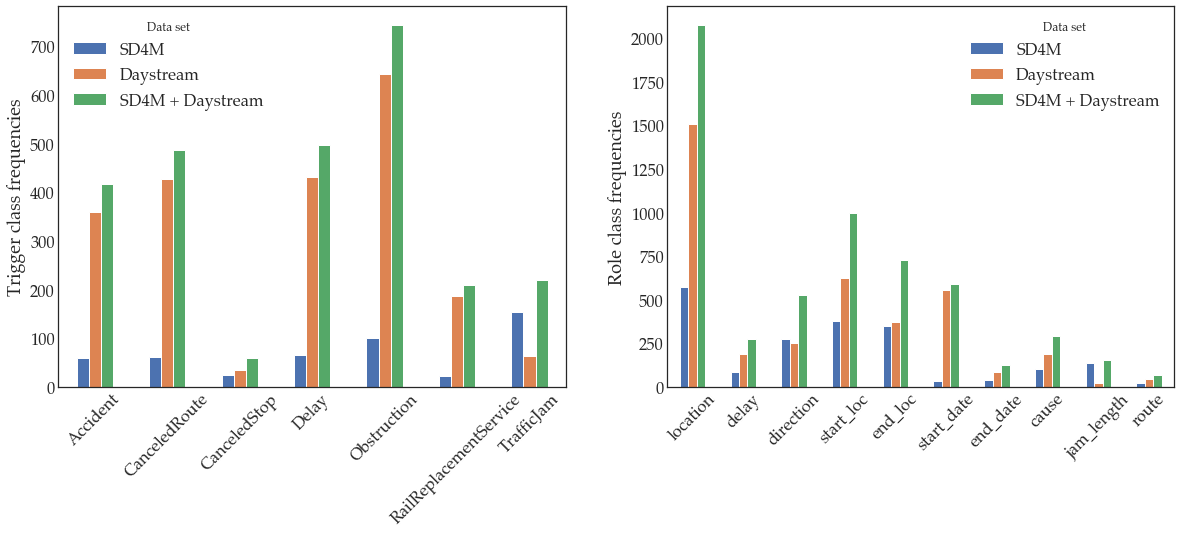

In [36]:
sns.set(font_scale=1.5, font="Palatino")
with plt.style.context("seaborn-white"):
    plt.rcParams["font.family"] = "Palatino"
    plt.rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(1, 2, figsize=(20,7))
    trigger_plot = trigger_stats_df[SD4M_RELATION_TYPES[:-1]].T.plot.bar(ax=ax[0])
    ax[0].set_ylabel('Trigger class frequencies')
    trigger_plot.set_xticklabels(trigger_plot.get_xticklabels(), rotation = 45)
    role_plot = role_stats_df[ROLE_LABELS[:-1]].T.plot.bar(ax=ax[1])
    ax[1].set_ylabel('Role class frequencies')
    role_plot.set_xticklabels(role_plot.get_xticklabels(), rotation = 45)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.savefig(SAVE_PATH.joinpath('TrainingDataClassDist.pdf'), bbox_inches='tight')

### Statistics about the SD4M data
(After removing the documents without triggers )

In [37]:
sd4m_dev = pd.read_json(DEV_PATH, lines=True, encoding='utf8')
sd4m_dev_filtered = sd4m_dev[sd4m_dev.apply(lambda document: corpus_statistics.has_triggers(document), axis=1)]
sd4m_test = pd.read_json(TEST_PATH_SF, lines=True, encoding='utf8')
sd4m_test_filtered = sd4m_test[sd4m_test.apply(lambda document: corpus_statistics.has_triggers(document), axis=1)]
sd4m_statistics = [
    corpus_statistics.get_event_stats(sd4m_train_filtered),
    corpus_statistics.get_event_stats(sd4m_dev_filtered),
    corpus_statistics.get_event_stats(sd4m_test_filtered)
]
general_stats = [{x: data_stat[x] for x in data_stat if x not in ['Trigger class frequencies', 'Role class frequencies']} for data_stat in sd4m_statistics]
general_stats_df = convert_to_stats_df(general_stats, data_sets=["SD4M Train", "SD4M Dev", "SD4M Test"])
trigger_stats = [data_stat['Trigger class frequencies'] for data_stat in sd4m_statistics]
trigger_stats_df = convert_to_stats_df(trigger_stats, data_sets=["SD4M Train", "SD4M Dev", "SD4M Test"])
role_stats = [data_stat['Role class frequencies'] for data_stat in sd4m_statistics]
role_stats_df = convert_to_stats_df(role_stats, data_sets=["SD4M Train", "SD4M Dev", "SD4M Test"])

In [38]:
display(general_stats_df.T)
display(trigger_stats_df.T)
display(role_stats_df.T)

Data set,SD4M Train,SD4M Dev,SD4M Test
# Docs,567,55,68
# Docs with event triggers,413,41,48
# Event triggers with positive label,488,46,57
# Event triggers with negative label,289,25,40
# Event triggers with abstain,0,0,0
# Docs with event roles,413,41,48
# Event role with positive label,2001,195,242
# Event roles with negative label,5284,296,601
# Event roles with abstain,0,0,0


Data set,SD4M Train,SD4M Dev,SD4M Test
Accident,59,6,9
CanceledRoute,61,2,10
CanceledStop,25,1,3
Delay,65,9,2
Obstruction,101,9,12
RailReplacementService,22,4,5
TrafficJam,155,15,16
O,289,25,40


Data set,SD4M Train,SD4M Dev,SD4M Test
location,571,58,84
delay,87,14,8
direction,277,32,31
start_loc,377,32,38
end_loc,352,30,39
start_date,35,3,8
end_date,41,4,3
cause,103,9,15
jam_length,135,12,13
route,23,1,3


### Does increasing the amount of snorkel labeled training data improve model performance?
Compare model performance with increasing amount of snorkel labeled data.
We sample 50%, 60%, ..., 100% from the Daystream data. We do this 5 random repeats for each sample size and look at the macro averaged f1-score.

In [39]:
# increasing training data over 5 different sample runs
model_names_increasing_data = [f'daystream{percentage}_snorkeled' for percentage in range(50,101,10)]
model_base_path = Path("../../data/runs/single_rr_increasing_train_data")
runs = 5
increasing_data_save_file = SAVE_PATH.joinpath("single_rr_increasing_train_data_save_file.pkl")   # if the models don't change, we can use this instead rerunning all the models
if increasing_data_save_file.exists() and SAVE_METRICS_PREDICTIONS:
    print(f"Loading metrics from {increasing_data_save_file}, using those instead of running predictions")
    trigger_metrics, argument_metrics = pickle.load(open(increasing_data_save_file, "rb")) 
else:
    trigger_metrics, argument_metrics = {}, {}
    for model_name in model_names_increasing_data:
        print(model_name)
        model_paths = [model_base_path.joinpath(f'run_{run+1}/{model_name}') for run in range(runs)]
        trigger_metrics[model_name], argument_metrics[model_name] = evaluate.summize_multiple_runs(model_paths, test_docs)
    if SAVE_METRICS_PREDICTIONS:
        print(f"Saving metrics to {increasing_data_save_file}")    
        pickle.dump((trigger_metrics, argument_metrics), open(increasing_data_save_file, "wb"))

Loading metrics from ../../data/save_files/single_rr_increasing_train_data_save_file.pkl, using those instead of running predictions


In [40]:
def get_infos(metrics, metric_name, labels=None):
    table = []
    for idx, (k,v) in enumerate(metrics.items()):
        if labels is None:
            tmp = {'Model': k}
        else:
            tmp = {'Sample size in %': labels[idx]}
        tmp[metric_name] = np.mean(v[metric_name]['f1-score'])*100  # f1-mean turn into percentage
        tmp['f1-std'] = np.std(v[metric_name]['f1-score'])*100  # f1-std turn into percentage
        table.append(tmp)
    if labels is None:
        return pd.DataFrame(table).set_index('Model')
    else:
        return pd.DataFrame(table).set_index('Sample size in %')

In [41]:
sample_sizes = [percentage for percentage in range(50,101,10)]
t_id_table = get_infos(trigger_metrics, 'Trigger identification', labels=sample_sizes)
t_class_table = get_infos(trigger_metrics, 'Trigger classification', labels=sample_sizes)
a_id_table = get_infos(argument_metrics, 'Argument identification', labels=sample_sizes)
a_class_table = get_infos(argument_metrics, 'Argument classification', labels=sample_sizes)

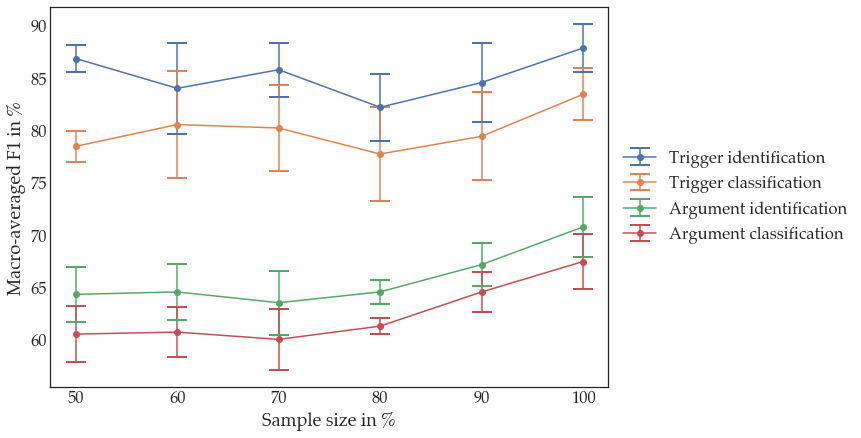

In [42]:
sns.set(font_scale=1.5, font="Palatino")
with plt.style.context("seaborn-white"):
    plt.rcParams["font.family"] = "Palatino"
    plt.rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_ylabel('Macro-averaged F1 in %')
    for table, name in zip([t_id_table, t_class_table, a_id_table, a_class_table], ['Trigger identification', 'Trigger classification', 'Argument identification', 'Argument classification']):
        table.plot(ax=ax, y=name, yerr=table['f1-std'], grid=False, capsize=10, capthick=2, marker="o")
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    fig.savefig(SAVE_PATH.joinpath('IncreasingTrainData.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')

In [43]:
formatted_metrics_increasing_data = {}
for model_name in model_names_increasing_data:
    formatted_trigger = evaluate.format_classification_report(evaluate.get_mean_std(trigger_metrics[model_name]), make_string=True)
    formatted_argument = evaluate.format_classification_report(evaluate.get_mean_std(argument_metrics[model_name]), make_string=True)
    formatted_metrics_increasing_data[model_name] = pd.concat([formatted_trigger, formatted_argument])
    formatted_metrics_increasing_data[model_name].set_index('row_name', inplace=True)

In [44]:
complete_metrics_increasing_data = pd.concat(formatted_metrics_increasing_data.values(), axis=1, keys=formatted_metrics_increasing_data.keys())
# display(complete_metrics_increasing_data.T[trigger_related_categories])
# display(complete_metrics_increasing_data.T[role_related_categories])

In [45]:
complete_metrics_increasing_data.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'f1-score']]].T[trigger_related_categories]

,row_name,Trigger identification,Trigger classification,Accident,CanceledRoute,CanceledStop,Delay,Obstruction,RailReplacementService,TrafficJam
daystream50_snorkeled,f1-score,86.9+/- 1.3,78.5+/- 1.5,80.8+/- 1.7,72.7+/- 9.7,36.0+/- 44.5,100.0+/- 0.0,79.6+/- 4.2,77.8+/- 5.6,79.8+/- 2.5
daystream60_snorkeled,f1-score,84.0+/- 4.3,80.5+/- 5.1,86.3+/- 2.6,62.6+/- 24.9,58.0+/- 31.2,100.0+/- 0.0,83.9+/- 3.5,67.9+/- 8.7,84.5+/- 2.0
daystream70_snorkeled,f1-score,85.8+/- 2.6,80.2+/- 4.1,83.2+/- 3.0,73.3+/- 19.6,72.0+/- 19.4,82.7+/- 15.0,79.1+/- 7.2,67.9+/- 8.7,85.0+/- 1.9
daystream80_snorkeled,f1-score,82.2+/- 3.2,77.7+/- 4.5,86.3+/- 3.2,55.7+/- 38.5,0.0+/- 0.0,96.0+/- 8.0,82.5+/- 4.2,60.7+/- 7.1,84.2+/- 3.9
daystream90_snorkeled,f1-score,84.6+/- 3.8,79.4+/- 4.2,83.3+/- 4.0,67.3+/- 20.0,26.0+/- 33.2,100.0+/- 0.0,79.6+/- 5.5,77.8+/- 5.6,84.8+/- 2.2
daystream100_snorkeled,f1-score,87.9+/- 2.3,83.4+/- 2.5,88.5+/- 3.6,79.2+/- 5.6,26.0+/- 33.2,93.3+/- 13.3,85.3+/- 2.5,77.8+/- 5.6,86.8+/- 3.7


In [46]:
complete_metrics_increasing_data.loc[pd.IndexSlice[:, pd.IndexSlice[:, 'f1-score']]].T[role_related_categories]

,row_name,Argument identification,Argument classification,location,delay,direction,start_loc,end_loc,start_date,end_date,cause,jam_length,route
daystream50_snorkeled,f1-score,64.3+/- 2.7,60.5+/- 2.7,44.5+/- 6.1,0.0+/- 0.0,66.5+/- 4.4,72.3+/- 2.6,64.4+/- 4.5,34.3+/- 11.5,44.0+/- 4.9,81.6+/- 6.2,94.9+/- 1.7,0.0+/- 0.0
daystream60_snorkeled,f1-score,64.6+/- 2.7,60.7+/- 2.4,45.5+/- 6.2,0.0+/- 0.0,66.5+/- 7.3,67.8+/- 5.5,66.6+/- 4.3,35.1+/- 14.5,48.0+/- 4.0,82.3+/- 3.8,95.0+/- 2.7,10.0+/- 20.0
daystream70_snorkeled,f1-score,63.5+/- 3.1,60.0+/- 2.9,47.4+/- 4.3,0.0+/- 0.0,66.8+/- 9.8,66.0+/- 2.3,65.9+/- 3.8,35.6+/- 7.9,49.3+/- 9.8,76.5+/- 7.0,93.3+/- 4.5,0.0+/- 0.0
daystream80_snorkeled,f1-score,64.6+/- 1.1,61.3+/- 0.8,51.9+/- 2.5,8.4+/- 10.4,71.9+/- 2.9,65.6+/- 2.2,61.0+/- 3.2,33.0+/- 10.1,56.0+/- 12.0,77.5+/- 3.3,94.3+/- 2.7,0.0+/- 0.0
daystream90_snorkeled,f1-score,67.2+/- 2.0,64.6+/- 1.9,53.3+/- 4.8,0.0+/- 0.0,72.6+/- 2.0,73.3+/- 2.9,67.5+/- 3.4,40.8+/- 13.6,44.7+/- 6.9,79.2+/- 1.0,94.9+/- 1.7,0.0+/- 0.0
daystream100_snorkeled,f1-score,70.8+/- 2.9,67.5+/- 2.6,55.8+/- 7.6,0.0+/- 0.0,75.2+/- 3.8,75.4+/- 4.3,72.4+/- 3.1,47.8+/- 10.2,59.3+/- 12.2,82.1+/- 2.9,95.0+/- 2.7,0.0+/- 0.0


### Are there any benefits using Snorkel's Label Model over a simple Majority Label Voter?
Daystream (Label Model): 
- Model trained with probabilistically labeled Daystream data (using outputs from user-defined labeling functions weighted with Snorkel LabelModel)

Daystream (Majority Label Voter): 
- Model trained with probabilistically labeled Daystream data (using outputs from user-defined labeling functions with simple MajorityLabelVoter)
- `snorkel.labeling.model.baselines.MajorityLabelVote`
```python
    def predict_proba(self, L: np.ndarray) -> np.ndarray:
        """Predict probabilities using majority vote.

        Assign vote by calculating majority vote across all labeling functions.
        In case of ties, non-integer probabilities are possible.

        Parameters
        ----------
        L
            An [n, m] matrix of labels

        Returns
        -------
        np.ndarray
            A [n, k] array of probabilistic labels

        Example
        -------
        >>> L = np.array([[0, 0, -1], [-1, 0, 1], [1, -1, 0]])
        >>> maj_voter = MajorityLabelVoter()
        >>> maj_voter.predict_proba(L)
        array([[1. , 0. ],
               [0.5, 0.5],
               [0.5, 0.5]])
        """
        n, m = L.shape
        Y_p = np.zeros((n, self.cardinality))
        for i in range(n):
            counts = np.zeros(self.cardinality)
            for j in range(m):
                if L[i, j] != -1:
                    counts[L[i, j]] += 1
            Y_p[i, :] = np.where(counts == max(counts), 1, 0)  # assign probability 1.0 if class has most votes else 0.0
        Y_p /= Y_p.sum(axis=1).reshape(-1, 1)  # normalize in case of ties
        return Y_p
```


In [47]:
complete_metrics[["Daystream", "Daystream (Majority Label Voter)"]].T[trigger_related_categories]

row_name                                   Trigger identification  \
Daystream                        precision            92.3+/- 2.6   
                                 recall               83.9+/- 3.0   
                                 f1-score             87.9+/- 2.3   
                                 support                       57   
Daystream (Majority Label Voter) precision            90.9+/- 1.5   
                                 recall               84.9+/- 4.5   
                                 f1-score             87.8+/- 3.0   
                                 support                       57   

row_name                                   Trigger classification  \
Daystream                        precision            87.7+/- 2.4   
                                 recall               79.6+/- 3.3   
                                 f1-score             83.4+/- 2.5   
                                 support                       57   
Daystream (Majority Label Voter) precision            81.0+/- 4.6   
                                 recall               75.8+/- 7.3   
                                 f1-score             78.3+/- 6.0   
                                 support                       57   

row_name                                        Accident CanceledRoute  \
Daystream                        precision   84.6+/- 6.0  100.0+/- 0.0   
                                 recall      93.3+/- 5.4   66.0+/- 8.0   
                                 f1-score    88.5+/- 3.6   79.2+/- 5.6   
                                 support               9            10   
Daystream (Majority Label Voter) precision   77.7+/- 3.3   88.5+/- 6.3   
                                 recall     100.0+/- 0.0  60.0+/- 15.5   
                                 f1-score    87.4+/- 2.1  70.5+/- 10.2   
                                 support               9            10   

row_name                                    CanceledStop         Delay  \
Daystream                        precision  40.0+/- 49.0  100.0+/- 0.0   
                                 recall     20.0+/- 26.7  90.0+/- 20.0   
                                 f1-score   26.0+/- 33.2  93.3+/- 13.3   
                                 support               3             2   
Daystream (Majority Label Voter) precision  80.0+/- 40.0  80.0+/- 24.5   
                                 recall     60.0+/- 32.7  100.0+/- 0.0   
                                 f1-score   68.0+/- 34.9  86.7+/- 16.3   
                                 support               3             2   

row_name                                     Obstruction  \
Daystream                        precision   79.9+/- 4.3   
                                 recall      91.7+/- 0.0   
                                 f1-score    85.3+/- 2.5   
                                 support              12   
Daystream (Majority Label Voter) precision  70.7+/- 10.9   
                                 recall      81.7+/- 9.7   
                                 f1-score    75.1+/- 8.0   
                                 support              12   

row_name                                   RailReplacementService  \
Daystream                        precision           100.0+/- 0.0   
                                 recall               64.0+/- 8.0   
                                 f1-score             77.8+/- 5.6   
                                 support                        5   
Daystream (Majority Label Voter) precision           100.0+/- 0.0   
                                 recall               52.0+/- 9.8   
                                 f1-score             67.9+/- 8.7   
                                 support                        5   

row_name                                      TrafficJam  
Daystream                        precision   87.4+/- 3.9  
                                 recall      86.2+/- 4.7  
                                 f1-score    86.8+/- 3.7  
                       

In [48]:
complete_metrics[["Daystream", "Daystream (Majority Label Voter)"]].T[role_related_categories]

row_name                                   Argument identification  \
Daystream                        precision             82.6+/- 3.5   
                                 recall                62.1+/- 4.6   
                                 f1-score              70.8+/- 2.9   
                                 support                       244   
Daystream (Majority Label Voter) precision             72.9+/- 3.9   
                                 recall                58.1+/- 5.0   
                                 f1-score              64.6+/- 4.4   
                                 support                       244   

row_name                                   Argument classification  \
Daystream                        precision             78.9+/- 4.9   
                                 recall                59.2+/- 3.5   
                                 f1-score              67.5+/- 2.6   
                                 support                       244   
Daystream (Majority Label Voter) precision             69.2+/- 4.0   
                                 recall                55.2+/- 4.9   
                                 f1-score              61.4+/- 4.4   
                                 support                       244   

row_name                                       location         delay  \
Daystream                        precision  77.7+/- 3.3    0.0+/- 0.0   
                                 recall     44.3+/- 8.6    0.0+/- 0.0   
                                 f1-score   55.8+/- 7.6    0.0+/- 0.0   
                                 support             84             8   
Daystream (Majority Label Voter) precision  71.4+/- 7.4  40.0+/- 49.0   
                                 recall     43.8+/- 4.0   7.5+/- 10.0   
                                 f1-score   54.2+/- 4.6  12.4+/- 16.2   
                                 support             84             8   

row_name                                      direction    start_loc  \
Daystream                        precision  80.2+/- 7.1  75.9+/- 7.8   
                                 recall     71.0+/- 2.0  75.4+/- 2.6   
                                 f1-score   75.2+/- 3.8  75.4+/- 4.3   
                                 support             31           39   
Daystream (Majority Label Voter) precision  72.5+/- 6.1  67.6+/- 7.0   
                                 recall     68.4+/- 7.2  64.1+/- 9.7   
                                 f1-score   70.4+/- 6.5  65.3+/- 5.5   
                                 support             31           39   

row_name                                        end_loc    start_date  \
Daystream                        precision  78.9+/- 5.9  55.7+/- 13.4   
                                 recall     67.2+/- 2.5   42.2+/- 8.3   
                                 f1-score   72.4+/- 3.1  47.8+/- 10.2   
                                 support             39             9   
Daystream (Majority Label Voter) precision  63.4+/- 5.5  41.0+/- 19.7   
                                 recall     58.5+/- 5.0  44.4+/- 14.1   
                                 f1-score   60.8+/- 5.1  41.7+/- 15.8   
                                 support             39             9   

row_name                                        end_date        cause  \
Daystream                        precision  93.3+/- 13.3  90.1+/- 8.2   
                                 recall     46.7+/- 16.3  76.0+/- 3.3   
                                 f1-score   59.3+/- 12.2  82.1+/- 2.9   
                                 support               3           15   
Daystream (Majority Label Voter) precision  66.7+/- 27.9  92.3+/- 9.7   
                                 recall     40.0+/- 13.3  76.0+/- 5.3   
                                 f1-score    46.1+/- 8.4  83.3+/- 7.2   
                                 support               3           15   

row_name                                      jam_length         route  
Daystream                        precision